<a href="https://colab.research.google.com/github/conquerv0/MonetaryPolicy-StockReturns/blob/master/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf

In [ ]:
federal_fund = pd.read_csv('data/federal_fund_future_weekly.csv')

# Reformatting federal fund future date time variable to month-year
federal_fund = federal_fund.rename(columns={'Time':'Date', 'Last': 'FFF_Price', 'Change':'FFF_Change'})
federal_fund['Date'] = pd.to_datetime(federal_fund ['Date'])
federal_fund.sort_values(by='Date', ascending=True, inplace=True)
federal_fund['MonthYear'] = federal_fund['Date'].dt.to_period('M')
federal_fund['Week'] = federal_fund['Date'].dt.to_period('W').dt.start_time

# Calculate monthly change for the 30-day federal fund future.
# federal_fund['WeeklyChange'] = ((federal_fund['FFF_Price'] / federal_fund['FFF_Price'].shift(1)) -1)*100
federal_fund['M1_ImpliedRate'] = 100 - federal_fund['FFF_Price']

# Drop NA
federal_fund.dropna(axis=0, inplace=True)

federal_fund.tail()

,Symbol,Date,Open,High,Low,FFF_Price,FFF_Change,%Chg,Volume,Open Int,MonthYear,Week,M1_ImpliedRate
4,ZQG23,2023-02-06,95.4275,95.4325,95.4250,95.4300,0.0025,0.00%,562581.0,1627755.0,2023-02,2023-02-06,4.5700
3,ZQG23,2023-02-13,95.4325,95.4325,95.4275,95.4275,-0.0025,0.00%,523063.0,1715788.0,2023-02,2023-02-13,4.5725
2,ZQG23,2023-02-20,95.4275,95.4300,95.4275,95.4300,0.0025,0.00%,581493.0,1880126.0,2023-02,2023-02-20,4.5700
1,ZQG23,2023-02-27,95.4300,95.4300,95.1000,95.1150,-0.3150,-0.33%,457349.0,1679955.0,2023-02,2023-02-27,4.8850
0,ZQJ23,2023-03-06,95.1150,95.1250,94.9900,95.0350,-0.0800,-0.08%,649754.0,1378527.0,2023-03,2023-03-06,4.9650


In [ ]:
# Download data from yfinance API
spy = yf.download(tickers='SPY', start='2006-01-01', end='2023-3-8', interval='1wk')

# Calculate monthly return for the index
spy['WeeklyReturn'] = (spy['Close'] / spy['Close'].shift(1)) -1

# Reformat time period
spy['Date'] = pd.to_datetime(spy.index)
spy['MonthYear'] = spy['Date'].dt.to_period('M')
spy['Week'] = spy['Date'].dt.to_period('W').dt.start_time
spy = spy.assign(Index=range(len(spy))).set_index('Index')

# Drop NA
spy.dropna(axis=0, inplace=True)

spy.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,WeeklyReturn,Date,MonthYear,Week
Index,,,,,,,,,,
892,409.790009,416.489990,405.010010,408.040009,408.040009,376978100.0,-0.010452,2023-02-05,2023-02,2023-01-30
893,408.720001,415.049988,404.049988,407.260010,407.260010,380547800.0,-0.001912,2023-02-12,2023-02,2023-02-06
894,403.059998,404.160004,393.640015,396.380005,396.380005,370835000.0,-0.026715,2023-02-19,2023-02,2023-02-13
895,399.869995,404.450012,392.329987,404.190002,404.190002,451756200.0,0.019703,2023-02-26,2023-02,2023-02-20
896,405.049988,407.450012,396.589996,398.920013,398.920013,255853100.0,-0.013038,2023-03-05,2023-03,2023-02-27


In [ ]:
fed_spy_data = pd.merge(spy, federal_fund, on=['Week'])
fed_spy_data['Week'] = fed_spy_data['Week'].astype(str)
selected_columns = ['Week', 'WeeklyReturn', 'Close', 'FFF_Price', 'FFF_Change', '%Chg', 'M1_ImpliedRate']
fed_spy_data = fed_spy_data[selected_columns]
# data.drop(columns='Open', 'High','Low')
fed_spy_data.head()

,Week,WeeklyReturn,Close,FFF_Price,FFF_Change,%Chg,M1_ImpliedRate
0,2006-01-02,0.001869,128.679993,95.515,-0.015,-0.02%,4.485
1,2006-01-09,-0.021060,125.970001,95.510,-0.005,-0.01%,4.490
2,2006-01-16,0.020402,128.539993,95.510,0.000,0.00%,4.490
3,2006-01-23,-0.017660,126.269997,95.505,-0.005,-0.01%,4.495
4,2006-01-30,0.002930,126.639999,95.500,-0.005,-0.01%,4.500


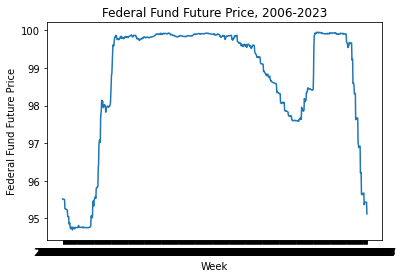

In [ ]:
# Create figure and plot space
plt.plot(fed_spy_data.Week,fed_spy_data.FFF_Price)


plt.title('Federal Fund Future Price, 2006-2023')
plt.xlabel('Week')
plt.ylabel('Federal Fund Future Price')
# plot.figsize((10,6))
plt.savefig('fff_price.png')

In [ ]:
fed_spy_data.to_stata('data/fed_spy_data.dta')

c:\ProgramData\Anaconda3\lib\site-packages\pandas\io\stata.py:2397: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    %Chg   ->   _Chg

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  warnings.warn(ws, InvalidColumnName)


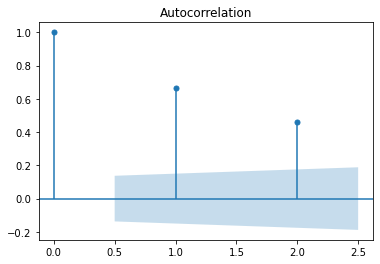

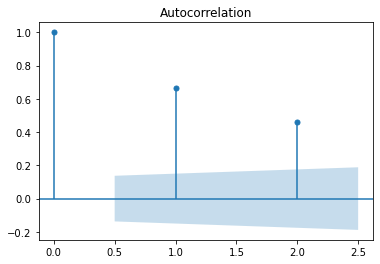

In [ ]:
plot_acf(fed_spy_data.MonthlyChange, lags = 2) 